In [48]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import itertools

In [49]:
with open('./pickles/allPixelNDVIPoly.pickle', 'rb') as handle:
    allPixelNDVIPoly3 = pickle.load(handle)

with open('./pickles/newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('./pickles/kmeans_total_3_c2.pickle', 'rb') as handle:
    kmeans_total3 = pickle.load(handle)

with open('./pickles/kmeans_total_3_c2.pickle', 'rb') as handle:
    kmeans_total3_master = pickle.load(handle)


In [50]:
# Numero di cluster 

num_cluster = 2
XMAx = 15
YMax = 15
allPixelNDVIPoly3 = allPixelNDVIPoly3[(newResa3<=11000) & (newResa3 >= 4000),:]
newResa3 = newResa3[(newResa3<=11000) & (newResa3 >= 4000)]

# Andiamo a calcolare una nuova metrica di coesione

In [51]:
km_one3 = TimeSeriesKMeans(n_clusters=num_cluster, metric="euclidean", max_iter=100,random_state=0)
y_pred_one3 = km_one3.fit_predict(allPixelNDVIPoly3)

(array([ 1.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  2.,  2.,  0.,  3.,  4.,
         5.,  3.,  2.,  7.,  6., 10.,  4.,  4., 12.,  7., 10., 12.,  4.,
         8.,  9., 11.,  8., 10., 19., 14., 12., 13., 23., 15., 20., 17.,
        16., 31., 28., 21., 39., 27., 32., 18., 42., 25., 30., 31., 31.,
        34., 33., 27., 37., 42., 43., 34., 29., 18., 39., 27., 26., 27.,
        36., 20., 28., 26., 20., 24., 18., 24., 21., 19., 14., 24., 17.,
        13., 16., 16.,  5.,  9., 11.,  9.,  6.,  6.,  3.,  4.,  3.,  3.,
         2.,  0.,  1.,  0.,  2.,  1.,  0.,  0.,  1.]),
 array([ 4026.30004883,  4093.73803711,  4161.17626953,  4228.61425781,
         4296.05224609,  4363.49023438,  4430.92822266,  4498.36621094,
         4565.80419922,  4633.2421875 ,  4700.68017578,  4768.11816406,
         4835.55615234,  4902.99414062,  4970.43212891,  5037.87011719,
         5105.30810547,  5172.74609375,  5240.18408203,  5307.62207031,
         5375.06005859,  5442.49804688,  5509.93603516,  5577.37402344,
  

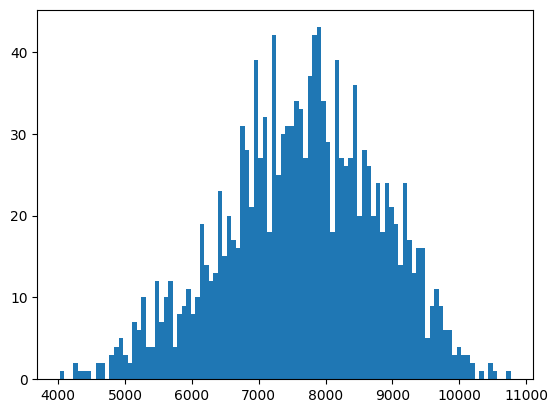

In [52]:
plt.hist(newResa3,100)

In [53]:
label_3 = np.ndarray([newResa3.shape[0]])
label_3_test = np.ndarray([newResa3.shape[0]])

for a,b in zip(newResa3,range(newResa3.shape[0])):
    if(a < np.quantile(newResa3,q=0.5)):
        label_3[b] = int(0) # resa bassa
        label_3_test[b] = int(0) # resa bassa
    #elif(a > np.quantile(newResa3,q=0.33) and a < np.quantile(newResa3,q=0.66)):
    else:
        label_3[b] = int(1) # resa alta
        label_3_test[b] = int(1) # resa alta

In [54]:
cluster_class_mapping = {}
df = pd.DataFrame(data=[])
for cluster in range(0,num_cluster):
    cluster_classes = label_3[y_pred_one3 == cluster]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    df[cluster] = class_counts
    print('Questo è class count '+ str(class_counts))
    print('Questo è class unique ',unique_classes)
    cluster_class_mapping[cluster] = dominant_class
print(df)

Questo è class count [406 127]
Questo è class unique  [0. 1.]
Questo è class count [329 609]
Questo è class unique  [0. 1.]
     0    1
0  406  329
1  127  609


In [55]:
def best_cluster(matrice):
    a = np.arange(matrice.shape[0])
    permutation = list(itertools.permutations(a))
    obiettivo = {'max': 0,
                'perm':[]}

    for perm in permutation:
        somma = 0
        for elem,index in zip(perm,range(matrice.shape[0])):
            somma += matrice[index,elem]
        if(somma > obiettivo['max']):
            obiettivo['max'] = somma
            obiettivo['perm'] = perm

    test_map = {}
    for pippo,pluto in zip(obiettivo['perm'],range(matrice.shape[0])):
        test_map[pluto] = pippo
    return test_map

                 

In [56]:
# Associazione del cluster i-esimo con la classe i-esima

list_of_mapping = []

for x in range(0,XMAx):

    list_of_mapping.append([])

    for y in range(0,YMax):

        if(kmeans_total3[x,y] is not None):

            cluster_class_mapping = {}
            matrice_elementi = np.ndarray((num_cluster,num_cluster))

            for cluster in range(0,num_cluster):

                cluster_classes = label_3[kmeans_total3[x,y] == cluster]
                unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
                
                if(len(class_counts) < num_cluster):
                    full = np.arange(num_cluster)
                    for a in list(set(full)-set(unique_classes)):
                        class_counts = np.insert(class_counts,values=0,obj=a)
                        
                    matrice_elementi[cluster,:] = class_counts
                else:
                    matrice_elementi[cluster,:] = class_counts


            list_of_mapping[-1].append(best_cluster(matrice_elementi))    
        else:
            continue

In [57]:
for a in range(len(list_of_mapping)):
    for b in range(len(list_of_mapping[a])):
        print(list_of_mapping[a][b])

{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}

In [58]:
list_of_difference = []

for a in range(len(list_of_mapping)):

    list_of_difference.append([])
    for b in range(len(list_of_mapping[a])):

        difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])
        for i in range(num_cluster):
            if(i != list_of_mapping[a][b][i]):

                new_row = pd.Series({'num_cluster': i, 'num_class': list_of_mapping[a][b][i]})
                difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)
        
        list_of_difference[-1].append(difference)

In [59]:
for a in range(len(list_of_difference)):
    for b in range(len(list_of_difference[a])):
        print(list_of_difference[a][b])

Empty DataFrame
Columns: [num_cluster, num_class]
Index: []
Empty DataFrame
Columns: [num_cluster, num_class]
Index: []
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
Empty DataFrame
Columns: [num_cluster, num_class]
Index: []
Empty DataFrame
Columns: [nu

In [60]:
for x in range(len(list_of_difference)):
    for y in range(len(list_of_difference[x])):
        indici = []
        if(kmeans_total3[x,y] is not None):
            for a in list_of_difference[x][y]['num_cluster']:
                indici.append([
                index for index in range(len(kmeans_total3[x,y]))
                if kmeans_total3[x,y][index] == a
            ])
            for ind,true_value in zip(indici,list_of_difference[x][y]['num_class']):
                kmeans_total3[x,y][ind] = true_value
        else:
            continue

In [61]:
list_of_mapping_test = []

for x in range(0,int(155/5)):

    list_of_mapping_test.append([])
    for y in range(0,int(155/5)):

        if(kmeans_total3[x,y] is not None):

            cluster_class_mapping = {}
            matrice_elementi = np.ndarray((num_cluster,num_cluster))
            for cluster in range(0,num_cluster):

                cluster_classes = label_3[kmeans_total3[x,y] == cluster]
                unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
                if(len(class_counts) < num_cluster):

                    full = np.arange(num_cluster)
                    for a in list(set(full)-set(unique_classes)):

                        class_counts = np.insert(class_counts,values=0,obj=a)
                    matrice_elementi[cluster,:] = class_counts
                else:
                    matrice_elementi[cluster,:] = class_counts
            list_of_mapping_test[-1].append(best_cluster(matrice_elementi))    
        else:
            continue

In [62]:
for a in range(len(list_of_mapping_test)):
    for b in range(len(list_of_mapping_test[a])):
        print(list_of_mapping_test[a][b])

{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}

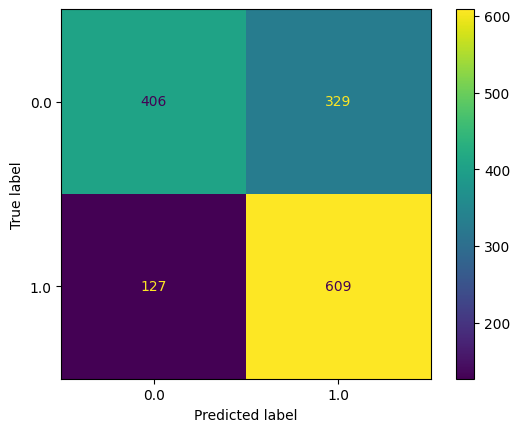

In [63]:
ConfusionMatrixDisplay.from_predictions(label_3,y_pred_one3)
plt.show()

In [64]:
accuracy = str(accuracy_score(label_3,y_pred_one3))
precision = str(precision_score(label_3,y_pred_one3,average= None))
recall = str(recall_score(label_3,y_pred_one3,average= None))

print("accuratezza " + accuracy)
print("precision " + precision)
print("recall " + recall)

accuratezza 0.690006798096533
precision [0.76172608 0.64925373]
recall [0.55238095 0.82744565]


In [65]:
matrice_precision = np.zeros([XMAx,YMax])
matrice_recall = np.zeros([XMAx,YMax])
matrice_accuracy = np.zeros([XMAx,YMax])

for x in range(0,XMAx):

    for y in range(0,YMax):

        if(kmeans_total3[x,y] is not None):
            matrice_precision[x,y] = precision_score(label_3,kmeans_total3[x,y],average= 'macro')
            matrice_recall[x,y] = recall_score(label_3,kmeans_total3[x,y],average= 'macro')
            matrice_accuracy[x,y] = accuracy_score(label_3,kmeans_total3[x,y])

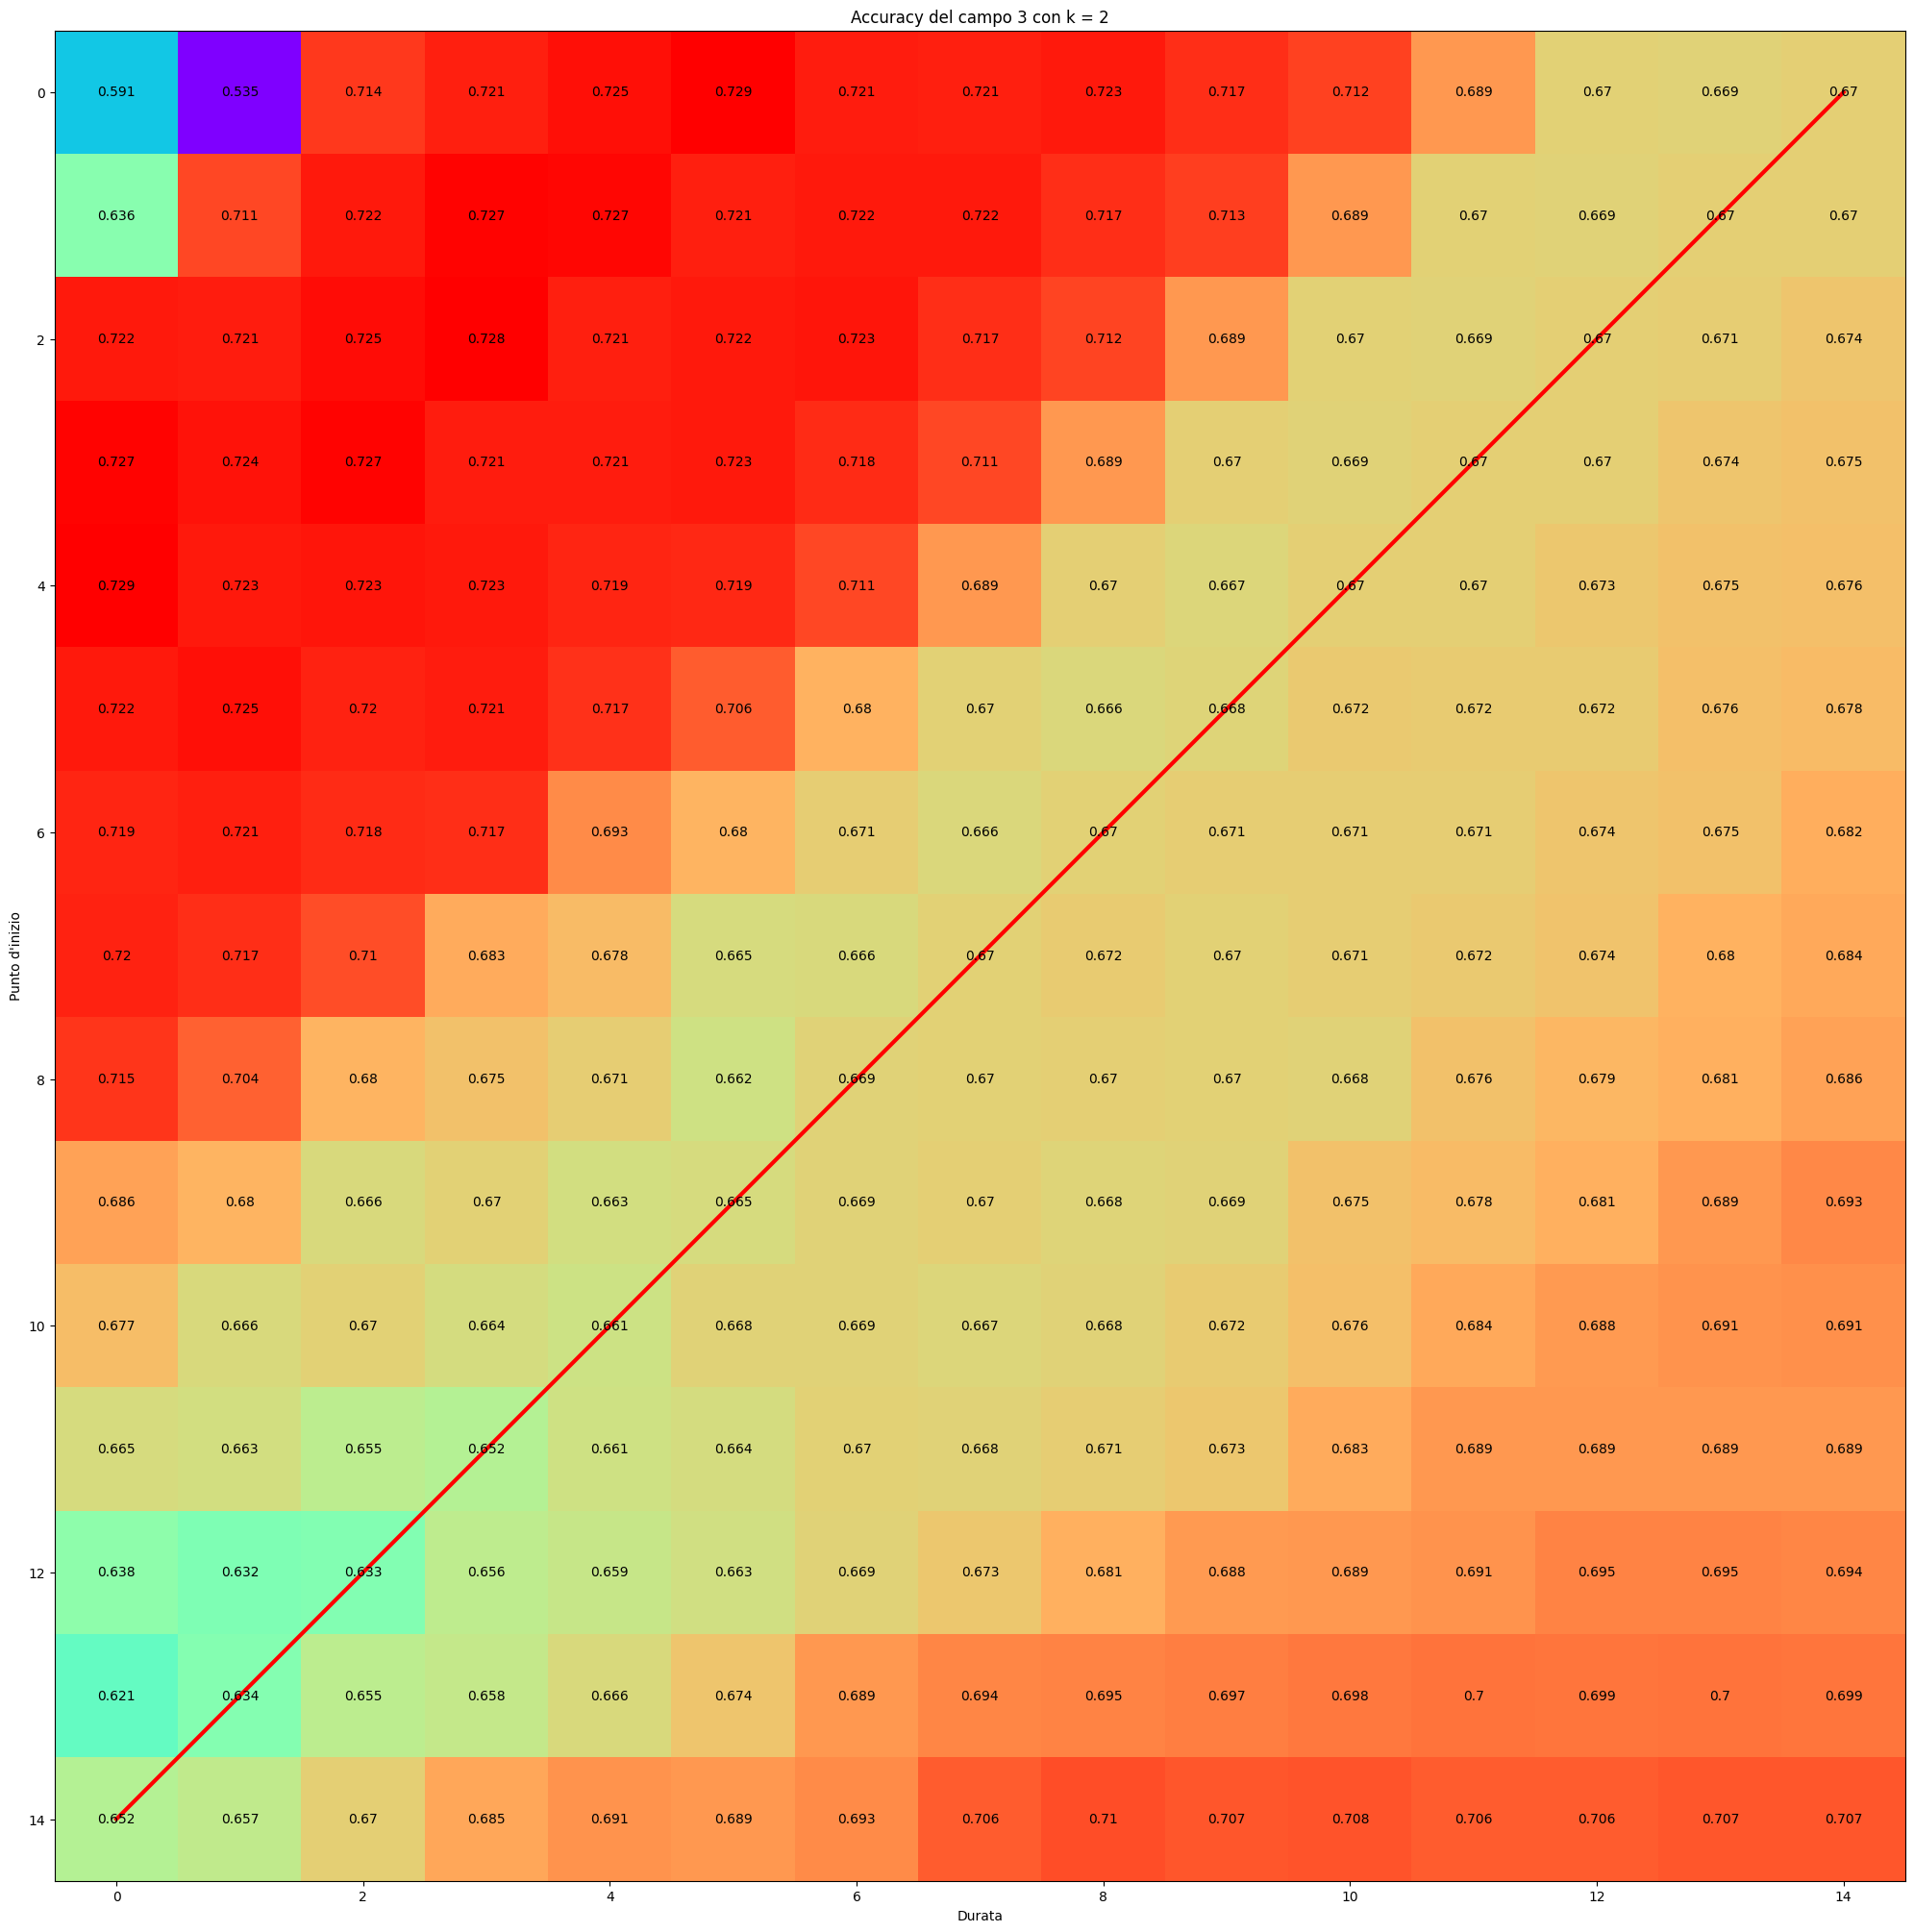

In [66]:
fig, ax = plt.subplots()
plt.rc('font', size=20)
image = ax.imshow(matrice_accuracy[:,:],cmap='rainbow')
line_start = [0, np.floor(71/5)]
line_end = [np.floor(71/5), 0]
plt.plot(line_start, line_end, color="red", linewidth=3)
plt.xlabel("Durata")
plt.ylabel("Punto d'inizio")
plt.title("Accuracy del campo 3 con k = 2")

fig.set_size_inches(25,25)
for i in range(XMAx):
    for j in range(YMax):
        c = np.round(matrice_accuracy[i,j],decimals=3)
        ax.text(j, i, str(c), va='center', ha='center')
plt.show()

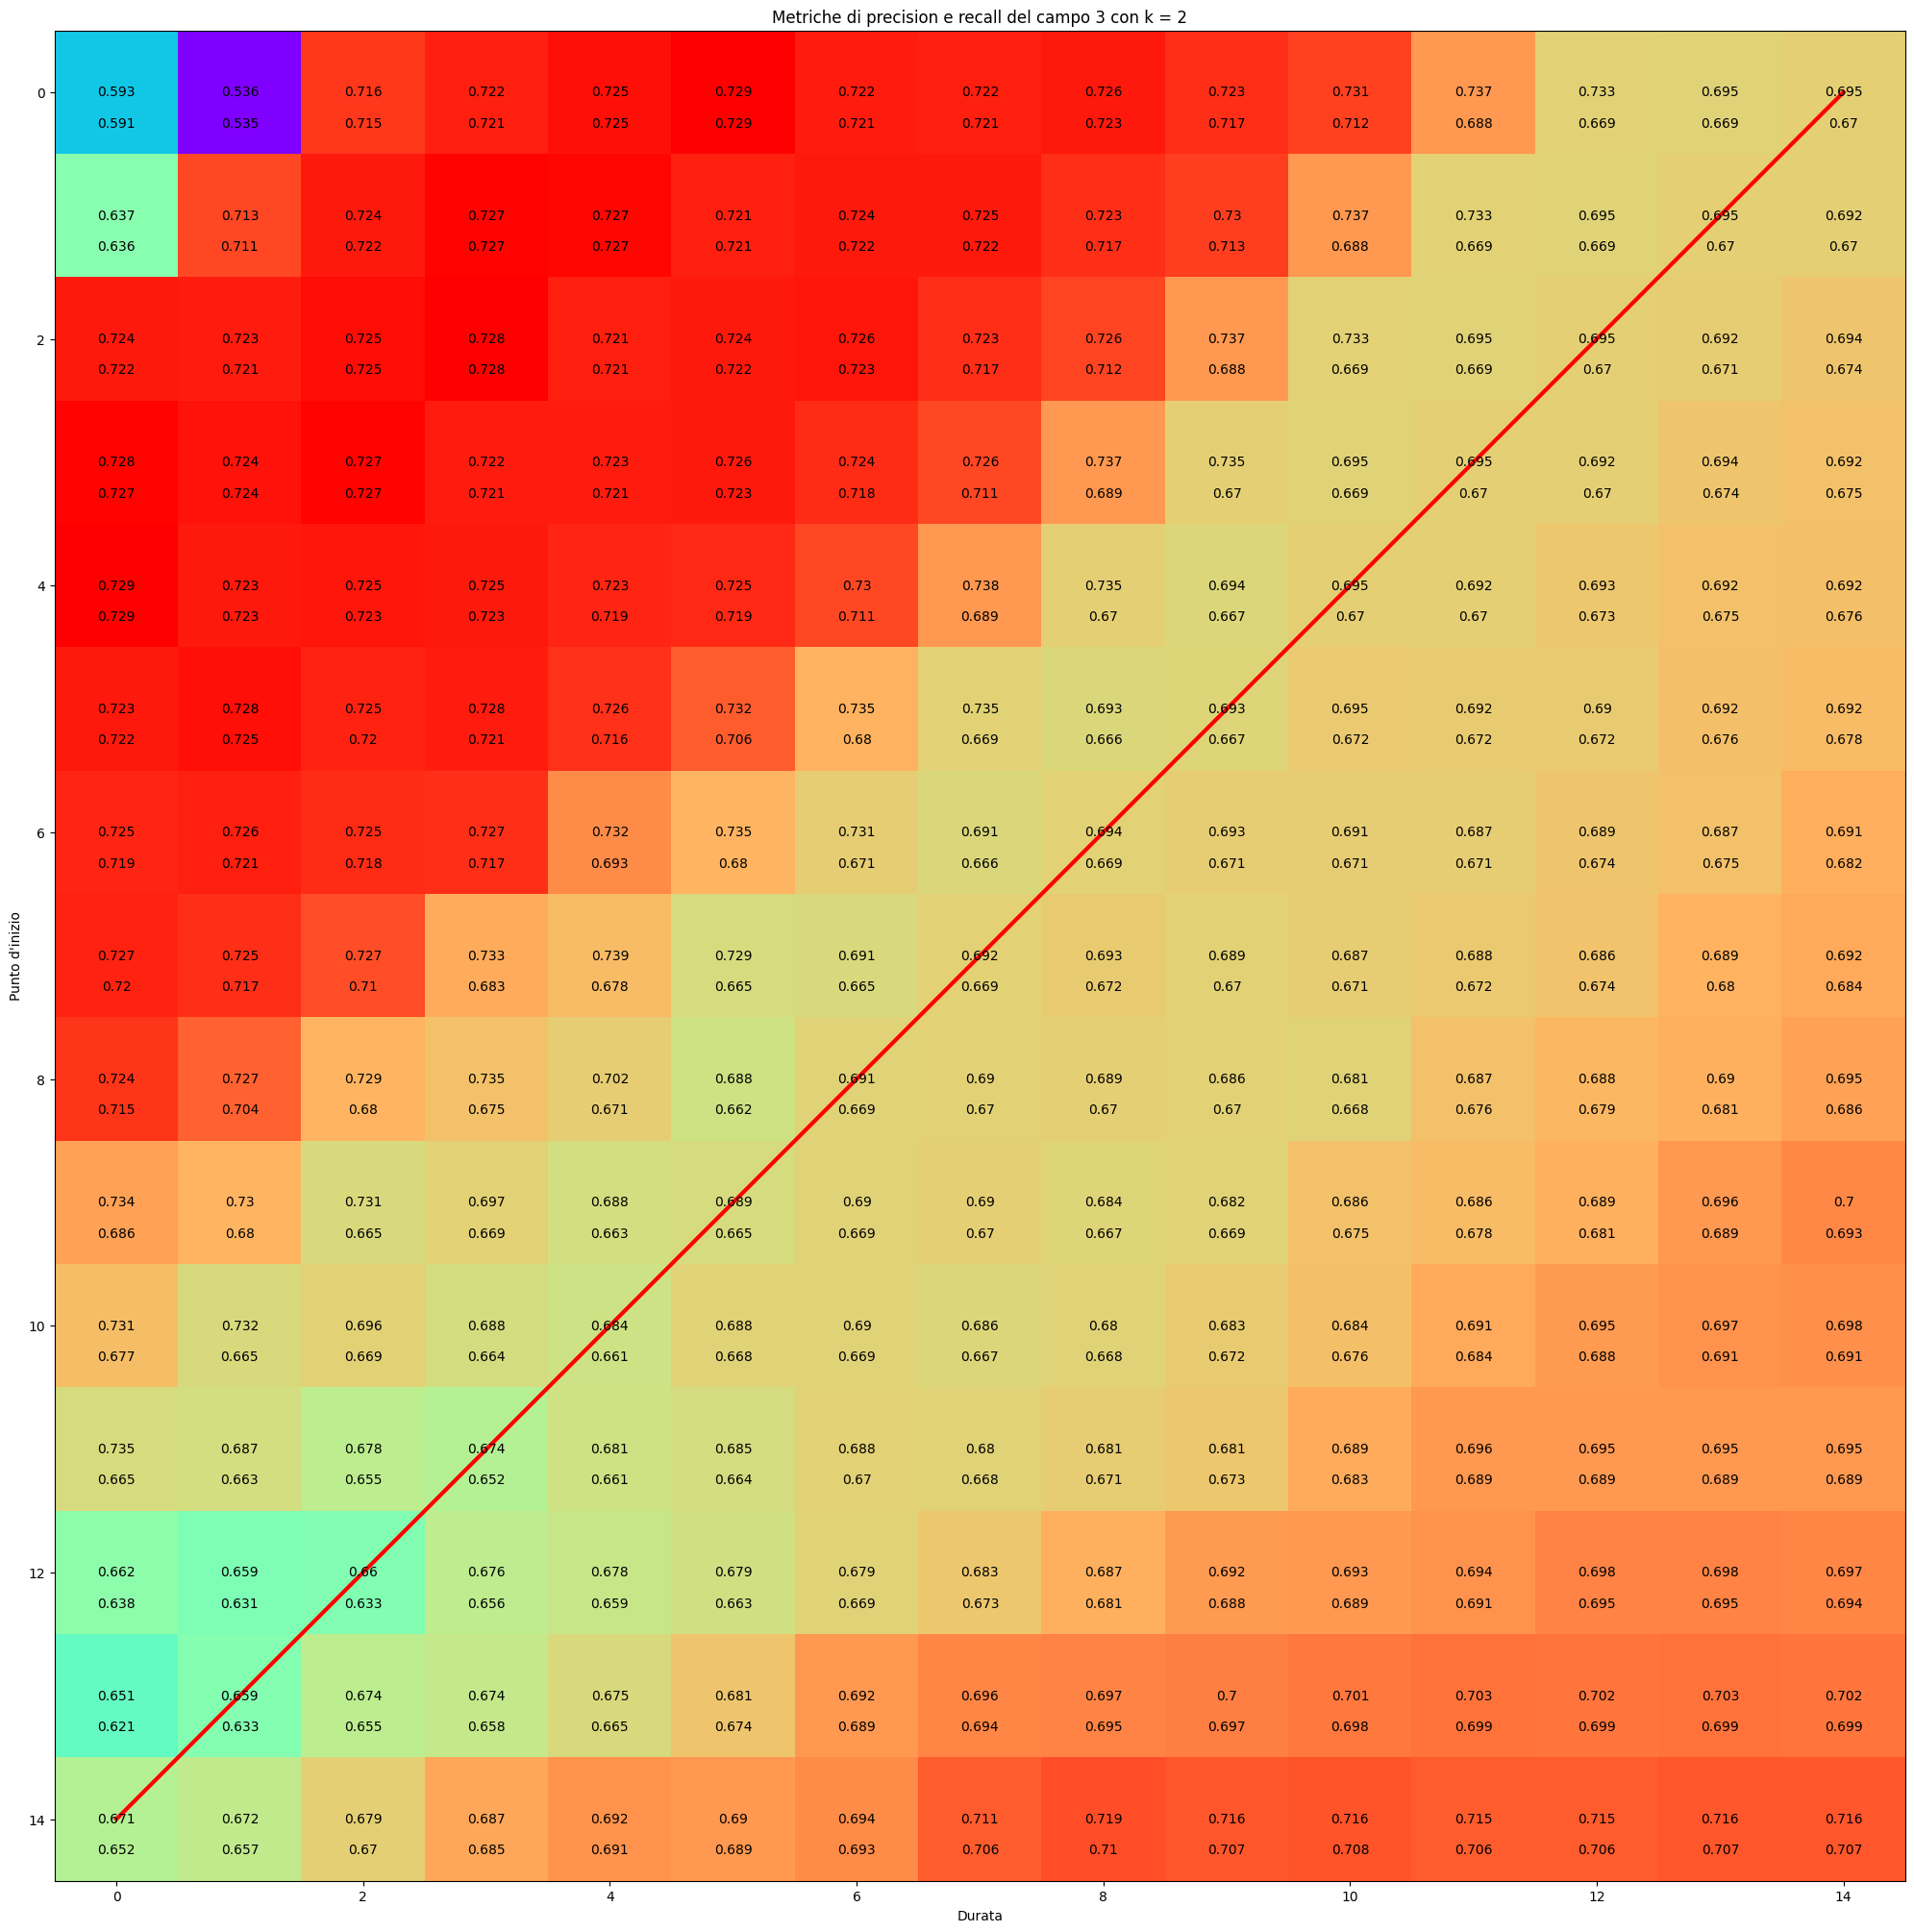

In [67]:
fig, ax = plt.subplots()
image = ax.imshow(matrice_accuracy[:,:],cmap='rainbow')
line_start = [0, np.floor(71/5)]
line_end = [np.floor(71/5), 0]
plt.plot(line_start, line_end, color="red", linewidth=3)
plt.xlabel("Durata")
plt.ylabel("Punto d'inizio")
plt.title('Metriche di precision e recall del campo 3 con k = 2')

fig.set_size_inches(25,25)
for i in range(XMAx):
    for j in range(YMax):
        c = np.round(matrice_precision[i,j],decimals=3)
        ax.text(j, i, str(c), va='center', ha='center')
        d = np.round(matrice_recall[i,j],decimals=3)
        ax.text(j,(i+0.25),str(d),va='center', ha='center')
plt.show()